In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time
pixel_well_depth = 20000
numchannel = 1
batch_size = 32

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
normal_train.shape

(580, 28, 28, 3)

In [3]:
def get_training_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_train//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_train//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.cast(tf.reduce_sum(
            tf.concat([x, y], axis=0), axis=0), tf.uint8), axis=-1, keepdims = True), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.reduce_sum(tf.cast(x, tf.uint8), axis=-1, keepdims=True), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.reduce_sum(tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), axis=-1, keepdims=True), [1,0]))
    dataset0 = dataset0.batch(16)
    
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

def get_testing_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.cast(tf.reduce_sum(
            tf.concat([x, y], axis=0), axis=0), tf.uint8), axis=-1, keepdims = True), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.reduce_sum(tf.cast(x, tf.uint8), axis=-1, keepdims=True), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.reduce_sum(tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), axis=-1, keepdims=True), [1,0]))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

In [4]:
def get_batch(n, istrain):
    if istrain == 0:
        x0, y0 = train_it0.get_next()
        x1, y1 = train_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = add_noise(x)
        y = tf.concat([y0,y1], axis=0)
    else:
        x0, y0 = test_it0.get_next()
        x1, y1 = test_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = add_noise(x)
        y = tf.concat([y0,y1], axis=0)     
    return x, y

In [5]:
def add_noise(x):
    noise = tf.random.normal(shape = tf.shape(x))
    noise = noise*tf.math.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth)
    x = tf.add(x, noise)
    return x

In [6]:
def pass_through_validation(sess, n = 0, numbatches = 50):
    val = 0
    for i in range(numbatches):
        val += sess.run(accuracy, feed_dict = {train_place: 1})
    return val/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    train_it0, train_it1 = get_training_iterator(n)
    test_it0, test_it1 = get_testing_iterator(n)
    train_place = tf.placeholder(tf.int8)
    images, label = get_batch(n, istrain=train_place)
    pred = CNN2(images, label, 2)
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=label)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(label,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (10):
        sess.run(tf.global_variables_initializer())
        sess.run(train_it0.initializer)
        sess.run(train_it1.initializer)
        sess.run(test_it0.initializer)
        sess.run(test_it1.initializer)
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            _, tloss = sess.run([train_op, loss], feed_dict={train_place: 0})
            train_losses.append(tloss)
            if i%250==0:
                prediction = list()
                y_label = list()
                val_losses.append(pass_through_validation(sess, n, numbatches=20))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    acc.append(Accuracy)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 0.891918; batch Validation accuracy: 0.500000; Time passed in this loop: 8.36
iteration 50; batch classifier loss: 0.155156; batch Validation accuracy: 0.971875; Time passed in this loop: 8.81
iteration 100; batch classifier loss: 0.011225; batch Validation accuracy: 1.000000; Time passed in this loop: 9.25
iteration 150; batch classifier loss: 0.004133; batch Validation accuracy: 1.000000; Time passed in this loop: 9.69
iteration 200; batch classifier loss: 0.001792; batch Validation accuracy: 1.000000; Time passed in this loop: 10.12
iteration 250; batch classifier loss: 0.001306; batch Validation accuracy: 1.000000; Time passed in this loop: 10.56
iteration 0; batch classifier loss: 1.505479; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.166890; batch Validation accuracy: 0.979688; Time passed in this loop: 0.48
iteration 100; batch classifier loss: 0.006430; batch Validation accuracy: 1

iteration 250; batch classifier loss: 0.031446; batch Validation accuracy: 0.976562; Time passed in this loop: 2.30
iteration 0; batch classifier loss: 0.817478; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.141239; batch Validation accuracy: 0.956250; Time passed in this loop: 0.50
iteration 100; batch classifier loss: 0.053300; batch Validation accuracy: 0.968750; Time passed in this loop: 0.95
iteration 150; batch classifier loss: 0.060642; batch Validation accuracy: 0.976562; Time passed in this loop: 1.39
iteration 200; batch classifier loss: 0.100945; batch Validation accuracy: 0.962500; Time passed in this loop: 1.84
iteration 250; batch classifier loss: 0.019420; batch Validation accuracy: 0.981250; Time passed in this loop: 2.28
iteration 0; batch classifier loss: 0.744357; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.088150; batch Validation accuracy: 0.9

iteration 200; batch classifier loss: 0.121530; batch Validation accuracy: 0.960938; Time passed in this loop: 1.87
iteration 250; batch classifier loss: 0.059724; batch Validation accuracy: 0.932813; Time passed in this loop: 2.32
iteration 0; batch classifier loss: 1.047434; batch Validation accuracy: 0.496875; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.162273; batch Validation accuracy: 0.943750; Time passed in this loop: 0.51
iteration 100; batch classifier loss: 0.161913; batch Validation accuracy: 0.960938; Time passed in this loop: 0.96
iteration 150; batch classifier loss: 0.179619; batch Validation accuracy: 0.937500; Time passed in this loop: 1.40
iteration 200; batch classifier loss: 0.061563; batch Validation accuracy: 0.948438; Time passed in this loop: 1.86
iteration 250; batch classifier loss: 0.068980; batch Validation accuracy: 0.957812; Time passed in this loop: 2.30
iteration 0; batch classifier loss: 0.974160; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.200270; batch Validation accuracy: 0.934375; Time passed in this loop: 1.44
iteration 200; batch classifier loss: 0.093223; batch Validation accuracy: 0.926562; Time passed in this loop: 1.89
iteration 250; batch classifier loss: 0.131756; batch Validation accuracy: 0.935937; Time passed in this loop: 2.35
iteration 0; batch classifier loss: 1.687833; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 50; batch classifier loss: 0.277993; batch Validation accuracy: 0.901563; Time passed in this loop: 0.52
iteration 100; batch classifier loss: 0.155131; batch Validation accuracy: 0.931250; Time passed in this loop: 0.99
iteration 150; batch classifier loss: 0.189473; batch Validation accuracy: 0.932813; Time passed in this loop: 1.45
iteration 200; batch classifier loss: 0.194638; batch Validation accuracy: 0.934375; Time passed in this loop: 1.91
iteration 250; batch classifier loss: 0.252592; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.174467; batch Validation accuracy: 0.931250; Time passed in this loop: 1.00
iteration 150; batch classifier loss: 0.323423; batch Validation accuracy: 0.925000; Time passed in this loop: 1.47
iteration 200; batch classifier loss: 0.245850; batch Validation accuracy: 0.928125; Time passed in this loop: 1.93
iteration 250; batch classifier loss: 0.114701; batch Validation accuracy: 0.920312; Time passed in this loop: 2.41
iteration 0; batch classifier loss: 0.849154; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 50; batch classifier loss: 0.245591; batch Validation accuracy: 0.878125; Time passed in this loop: 0.54
iteration 100; batch classifier loss: 0.391828; batch Validation accuracy: 0.881250; Time passed in this loop: 1.00
iteration 150; batch classifier loss: 0.095264; batch Validation accuracy: 0.907813; Time passed in this loop: 1.47
iteration 200; batch classifier loss: 0.244315; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.279766; batch Validation accuracy: 0.848437; Time passed in this loop: 0.54
iteration 100; batch classifier loss: 0.183552; batch Validation accuracy: 0.878125; Time passed in this loop: 1.01
iteration 150; batch classifier loss: 0.234313; batch Validation accuracy: 0.900000; Time passed in this loop: 1.49
iteration 200; batch classifier loss: 0.254233; batch Validation accuracy: 0.889062; Time passed in this loop: 1.96
iteration 250; batch classifier loss: 0.361594; batch Validation accuracy: 0.903125; Time passed in this loop: 2.43
iteration 0; batch classifier loss: 0.761528; batch Validation accuracy: 0.500000; Time passed in this loop: 0.36
iteration 50; batch classifier loss: 0.313545; batch Validation accuracy: 0.853125; Time passed in this loop: 0.84
iteration 100; batch classifier loss: 0.442405; batch Validation accuracy: 0.864062; Time passed in this loop: 1.33
iteration 150; batch classifier loss: 0.488680; batch Validation accuracy: 0

iteration 0; batch classifier loss: 0.736886; batch Validation accuracy: 0.500000; Time passed in this loop: 0.08
iteration 50; batch classifier loss: 0.351166; batch Validation accuracy: 0.832812; Time passed in this loop: 0.57
iteration 100; batch classifier loss: 0.286242; batch Validation accuracy: 0.862500; Time passed in this loop: 1.07
iteration 150; batch classifier loss: 0.372258; batch Validation accuracy: 0.851562; Time passed in this loop: 1.56
iteration 200; batch classifier loss: 0.369851; batch Validation accuracy: 0.843750; Time passed in this loop: 2.05
iteration 250; batch classifier loss: 0.231595; batch Validation accuracy: 0.867188; Time passed in this loop: 2.55
iteration 0; batch classifier loss: 0.774031; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 50; batch classifier loss: 0.327909; batch Validation accuracy: 0.857812; Time passed in this loop: 0.57
iteration 100; batch classifier loss: 0.459193; batch Validation accuracy: 0.8

iteration 250; batch classifier loss: 0.212654; batch Validation accuracy: 0.882812; Time passed in this loop: 2.81
iteration 0; batch classifier loss: 0.746389; batch Validation accuracy: 0.500000; Time passed in this loop: 0.09
iteration 50; batch classifier loss: 0.393027; batch Validation accuracy: 0.825000; Time passed in this loop: 0.64
iteration 100; batch classifier loss: 0.372266; batch Validation accuracy: 0.843750; Time passed in this loop: 1.19
iteration 150; batch classifier loss: 0.364573; batch Validation accuracy: 0.843750; Time passed in this loop: 1.73
iteration 200; batch classifier loss: 0.241085; batch Validation accuracy: 0.857812; Time passed in this loop: 2.28
iteration 250; batch classifier loss: 0.257926; batch Validation accuracy: 0.878125; Time passed in this loop: 2.82
iteration 0; batch classifier loss: 1.503304; batch Validation accuracy: 0.500000; Time passed in this loop: 0.09
iteration 50; batch classifier loss: 0.357611; batch Validation accuracy: 0.8

iteration 200; batch classifier loss: 0.462143; batch Validation accuracy: 0.837500; Time passed in this loop: 2.34
iteration 250; batch classifier loss: 0.454405; batch Validation accuracy: 0.845313; Time passed in this loop: 2.90
iteration 0; batch classifier loss: 0.807223; batch Validation accuracy: 0.500000; Time passed in this loop: 0.10
iteration 50; batch classifier loss: 0.331753; batch Validation accuracy: 0.820312; Time passed in this loop: 0.65
iteration 100; batch classifier loss: 0.423565; batch Validation accuracy: 0.845313; Time passed in this loop: 1.23
iteration 150; batch classifier loss: 0.430391; batch Validation accuracy: 0.868750; Time passed in this loop: 1.78
iteration 200; batch classifier loss: 0.279932; batch Validation accuracy: 0.893750; Time passed in this loop: 2.33
iteration 250; batch classifier loss: 0.259361; batch Validation accuracy: 0.879687; Time passed in this loop: 2.90
iteration 0; batch classifier loss: 0.944225; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.342127; batch Validation accuracy: 0.839063; Time passed in this loop: 1.85
iteration 200; batch classifier loss: 0.312762; batch Validation accuracy: 0.828125; Time passed in this loop: 2.42
iteration 250; batch classifier loss: 0.372881; batch Validation accuracy: 0.854688; Time passed in this loop: 3.01
iteration 0; batch classifier loss: 0.820853; batch Validation accuracy: 0.500000; Time passed in this loop: 0.10
iteration 50; batch classifier loss: 0.413427; batch Validation accuracy: 0.806250; Time passed in this loop: 0.68
iteration 100; batch classifier loss: 0.333476; batch Validation accuracy: 0.821875; Time passed in this loop: 1.26
iteration 150; batch classifier loss: 0.439646; batch Validation accuracy: 0.818750; Time passed in this loop: 1.85
iteration 200; batch classifier loss: 0.441441; batch Validation accuracy: 0.828125; Time passed in this loop: 2.44
iteration 250; batch classifier loss: 0.349662; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.420089; batch Validation accuracy: 0.804688; Time passed in this loop: 1.34
iteration 150; batch classifier loss: 0.372361; batch Validation accuracy: 0.840625; Time passed in this loop: 1.95
iteration 200; batch classifier loss: 0.422491; batch Validation accuracy: 0.840625; Time passed in this loop: 2.56
iteration 250; batch classifier loss: 0.367304; batch Validation accuracy: 0.846875; Time passed in this loop: 3.17
iteration 0; batch classifier loss: 1.377494; batch Validation accuracy: 0.500000; Time passed in this loop: 0.11
iteration 50; batch classifier loss: 0.526489; batch Validation accuracy: 0.762500; Time passed in this loop: 0.72
iteration 100; batch classifier loss: 0.432218; batch Validation accuracy: 0.801562; Time passed in this loop: 1.33
iteration 150; batch classifier loss: 0.411408; batch Validation accuracy: 0.828125; Time passed in this loop: 1.94
iteration 200; batch classifier loss: 0.452965; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.477604; batch Validation accuracy: 0.778125; Time passed in this loop: 1.04
iteration 100; batch classifier loss: 0.419456; batch Validation accuracy: 0.823438; Time passed in this loop: 1.68
iteration 150; batch classifier loss: 0.286228; batch Validation accuracy: 0.820312; Time passed in this loop: 2.32
iteration 200; batch classifier loss: 0.318582; batch Validation accuracy: 0.840625; Time passed in this loop: 2.96
iteration 250; batch classifier loss: 0.302480; batch Validation accuracy: 0.843750; Time passed in this loop: 3.58
iteration 0; batch classifier loss: 0.777508; batch Validation accuracy: 0.500000; Time passed in this loop: 0.11
iteration 50; batch classifier loss: 0.409532; batch Validation accuracy: 0.817187; Time passed in this loop: 0.75
iteration 100; batch classifier loss: 0.353637; batch Validation accuracy: 0.795312; Time passed in this loop: 1.39
iteration 150; batch classifier loss: 0.405285; batch Validation accuracy: 0

iteration 0; batch classifier loss: 1.363608; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 50; batch classifier loss: 0.470630; batch Validation accuracy: 0.739062; Time passed in this loop: 0.77
iteration 100; batch classifier loss: 0.383042; batch Validation accuracy: 0.803125; Time passed in this loop: 1.43
iteration 150; batch classifier loss: 0.490618; batch Validation accuracy: 0.814063; Time passed in this loop: 2.09
iteration 200; batch classifier loss: 0.343104; batch Validation accuracy: 0.818750; Time passed in this loop: 2.75
iteration 250; batch classifier loss: 0.415089; batch Validation accuracy: 0.812500; Time passed in this loop: 3.40
iteration 0; batch classifier loss: 0.697183; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 50; batch classifier loss: 0.441477; batch Validation accuracy: 0.796875; Time passed in this loop: 0.77
iteration 100; batch classifier loss: 0.582992; batch Validation accuracy: 0.8

In [9]:
fulle - fulls

493.99658274650574

Text(0, 0.5, 'accuracy')

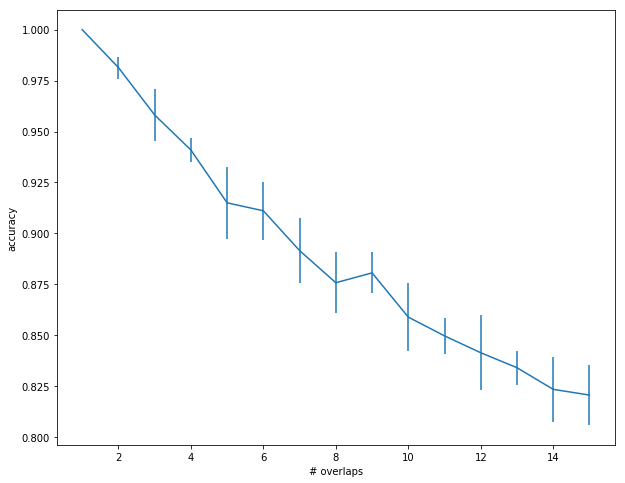

In [10]:
std = np.std(acc, axis=1)
mean = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(1,16), mean, yerr=[std, std])
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

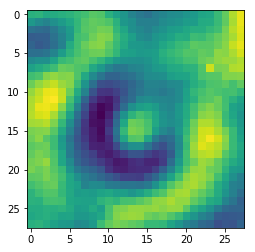

In [12]:
sess = tf.Session()
train_it0, train_it1 = get_training_iterator(n=4)
sess.run(tf.global_variables_initializer())
sess.run(train_it0.initializer)
sess.run(train_it1.initializer)
images, label = get_batch(n=4, istrain=0)
plt.imshow(sess.run(images)[19,:,:,0].astype(np.uint8))
sess.close()

In [13]:
np.save("accbase.npy",acc)